In [ ]:
!git clone https://github.com/lollcat/FAB-JAX

Cloning into 'FAB-JAX'...
remote: Enumerating objects: 228, done.
remote: Counting objects: 100% (228/228), done.
remote: Compressing objects: 100% (146/146), done.
remote: Total 228 (delta 100), reused 193 (delta 73), pack-reused 0
Receiving objects: 100% (228/228), 47.12 KiB | 11.78 MiB/s, done.
Resolving deltas: 100% (100/100), done.


In [ ]:
!pip install git+https://github.com/deepmind/dm-haiku
!pip install git+git://github.com/deepmind/distrax.git
!pip install git+git://github.com/deepmind/optax.git

  Cloning https://github.com/deepmind/dm-haiku to /tmp/pip-req-build-tzj3a23k
  Running command git clone -q https://github.com/deepmind/dm-haiku /tmp/pip-req-build-tzj3a23k
  Created wheel for dm-haiku: filename=dm_haiku-0.0.7.dev0-py3-none-any.whl size=562030 sha256=197d9b3eb191918d95e95389d9dad1ea52ee6dff147f15726eb02b4a5159917c
  Stored in directory: /tmp/pip-ephem-wheel-cache-292p4_15/wheels/06/28/69/ebaac5b2435641427299f29d88d005fb4e2627f4a108f0bdbc
Successfully built dm-haiku
  Cloning git://github.com/deepmind/distrax.git to /tmp/pip-req-build-bokrw5w4
  Running command git clone -q git://github.com/deepmind/distrax.git /tmp/pip-req-build-bokrw5w4
     |████████████████████████████████| 70 kB 1.1 MB/s 
  Created wheel for distrax: filename=distrax-0.1.1-py3-none-any.whl size=244235 sha256=937819cc28298cece090d29b0b8e2a6e0ace0fee9a6d78856c1e2623c19f4e44
  Stored in directory: /tmp/pip-ephem-wheel-cache-tbrfqzey/wheels/94/fe/e5/236820ed37542a45e3c765def1cc2035b462091f41ff06a397
S

In [ ]:
import os
os.chdir("FAB-JAX")

In [ ]:
from fab.learnt_distributions.distrax_realNVP_flo import make_realnvp_dist_funcs
from fab.target_distributions.many_well import ManyWellEnergy
from fab.agent.fab_agent import AgentFAB
from fab.utils.plotting import plot_history, plot_marginal_pair, plot_contours_2D
import matplotlib.pyplot as plt
import optax
import jax
import jax.numpy as jnp

In [52]:
dim = 8
flow_num_layers = 10
mlp_hidden_size_per_x_dim = 5 # originally was 5! 

In [53]:
real_nvp_flo = make_realnvp_dist_funcs(dim, flow_num_layers,
                                       mlp_hidden_size_per_x_dim=mlp_hidden_size_per_x_dim, use_exp=True)
target_log_prob = ManyWellEnergy(dim=dim).log_prob
batch_size = 1000
n_iter = int(1e4)
lr = 2e-4
n_intermediate_distributions: int = 2
AIS_kwargs = {"additional_transition_operator_kwargs": {"step_tuning_method": "p_accept"}}

In [54]:
fab_agent = AgentFAB(learnt_distribution=real_nvp_flo,
                     target_log_prob=target_log_prob,
                     batch_size=batch_size, n_iter=n_iter,
                     n_intermediate_distributions=n_intermediate_distributions,
                     AIS_kwargs=AIS_kwargs,
                     optimizer=optax.adam(lr))

using linear spacing as there is 2intermediate distribution


In [55]:
fab_agent.run()

ESS: 0.3345403361609855: 100%|██████████| 10000/10000 [05:29<00:00, 30.32it/s]


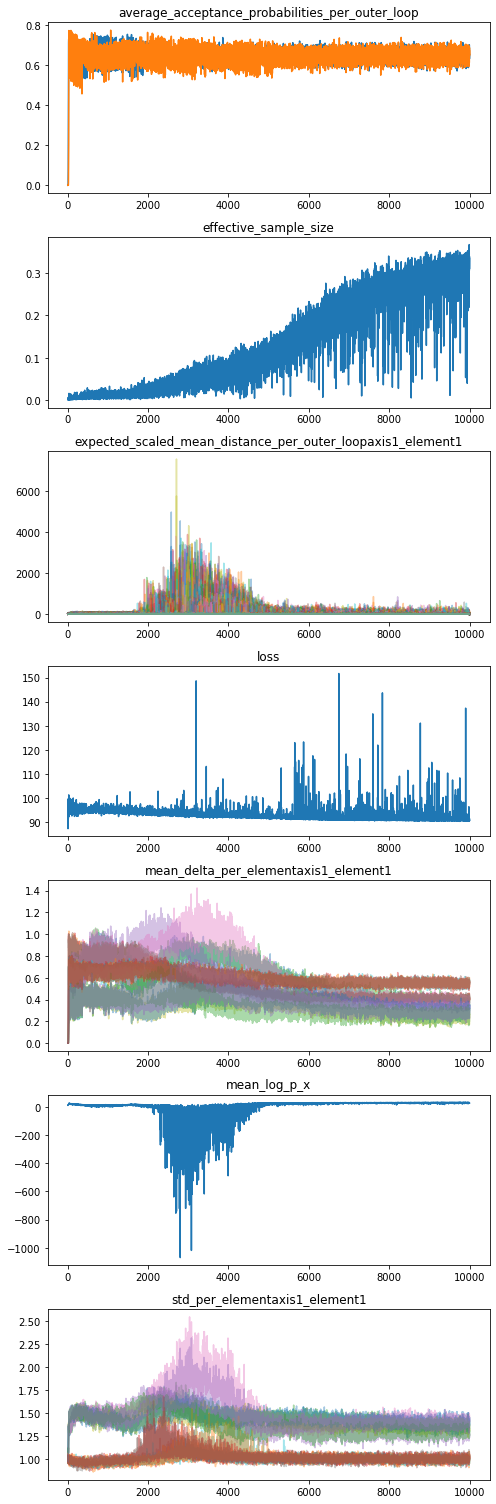

In [56]:
plot_history(fab_agent.history)
plt.show()

In [57]:
def plot(fab_agent, n_samples = batch_size, dim=dim, key=jax.random.PRNGKey(0)):
    plotting_bounds = 3
    target = ManyWellEnergy(dim=dim)
    n_rows = dim // 2
    fig, axs = plt.subplots(dim // 2, 2,  sharex=True, sharey=True, figsize=(10, n_rows*3))

    
    samples_flow = fab_agent.learnt_distribution.sample.apply(fab_agent.learnt_distribution_params, key, (batch_size,))
    samples_ais = fab_agent.annealed_importance_sampler.run(key, fab_agent.learnt_distribution_params)[0]

    for i in range(n_rows):
      plot_contours_2D(target.log_prob_2D, bound=plotting_bounds, ax=axs[i, 0])
      plot_contours_2D(target.log_prob_2D, bound=plotting_bounds, ax=axs[i, 1])

      # plot flow samples
      plot_marginal_pair(samples_flow, ax=axs[i, 0], bounds=(-plotting_bounds, plotting_bounds), marginal_dims=(i*2,i*2+1))
      axs[i, 0].set_xlabel(f"dim {i*2}")
      axs[i, 0].set_ylabel(f"dim {i*2 + 1}")
      


      # plot ais samples
      plot_marginal_pair(samples_ais, ax=axs[i, 1], bounds=(-plotting_bounds, plotting_bounds), marginal_dims=(i*2,i*2+1))
      axs[i, 1].set_xlabel(f"dim {i*2}")
      axs[i, 1].set_ylabel(f"dim {i*2+1}")
      plt.tight_layout()
    axs[0, 1].set_title("ais samples")  
    axs[0, 0].set_title("flow samples")
    plt.show()

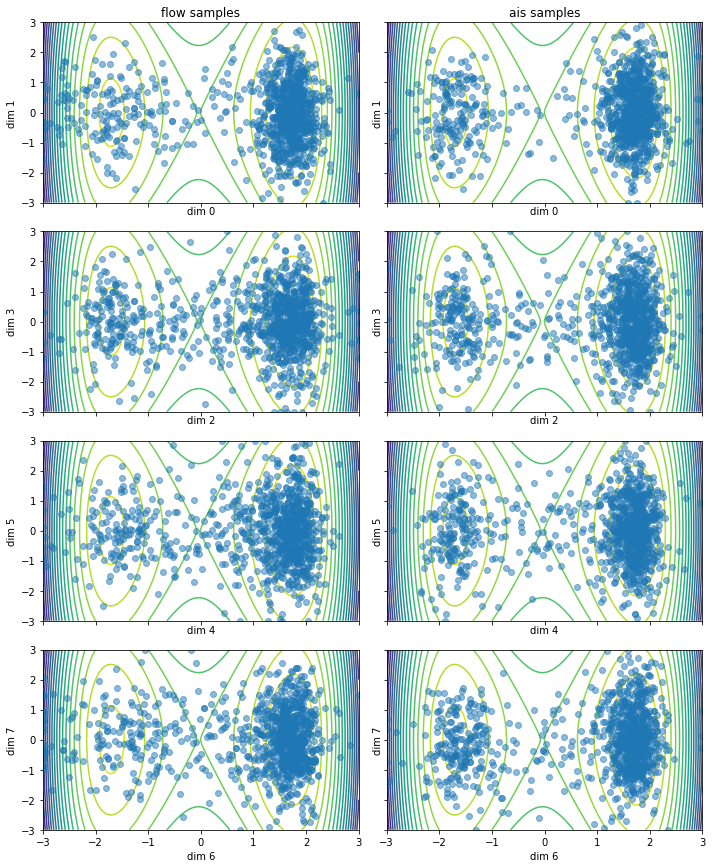

In [58]:
plot(fab_agent)

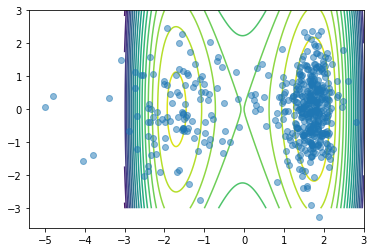

In [59]:
fig, ax = plt.subplots()
plot_contours_2D(ManyWellEnergy(dim=dim).log_prob_2D, ax=ax, bound=3, levels=20)
samples = fab_agent.learnt_distribution.sample.apply(
    fab_agent.learnt_distribution_params,
    jax.random.PRNGKey(0), (500,))
plot_marginal_pair(samples, ax=ax)
